In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 10e4
import cv2 as cv

In [396]:
import numpy as np
import usrLibrary20230404 as lib

# 1, setting parameters ---------------------------------------------------------------------------------------
# 1-1, optical condition
class optical_condition:
    L:      float # distance from the sample plane to the detector plane
    p:      float # pixel size of the detector
    Npixel: int   # window size of the probe function, object functions, and diffraction pattens
    energy: float # X-ray energy of the incident beam
    h:      float # plank constant
    c:      float # velocity of the light
    lamb:   float # wavelength
    k:      float # wavenumber
    dx:     float # pixel resolution at the sample plane
    DR:     float # dynamic range of the detector, for example, opt.DR = log10{1e7 (photons) / 1 (photon}
    Wnoise: bool  # flag to apply photon shot noise to each calculated diffraction pattern

opt        = optical_condition()
opt.L      = 3                                       # unit: m
opt.p      = 75e-6                                   # unit: m
opt.Npixel = 256                                    # unit: pixel
opt.energy = 5000                                    # unit: eV
opt.h      = 6.62607015e-34                          # unit: m^2 kg/s
opt.c      = 299792458                               # unit: m/s
opt.lamb   = (opt.h * 6.242e18) * opt.c / opt.energy # unit: m
opt.k      = 2 * np.pi / opt.lamb                    # unit: 1/m
opt.dx     = opt.L * opt.lamb / (opt.Npixel * opt.p) # unit: m/pixel
opt.DR     = 7
opt.Wnoise = True      

# 1-2, aperture condition
class aperture_condition:
    sideNumber:      int     # number of the side
    sideLength:      float   # length of a side
    Lpropagation:    float   # distance from the apterture to the sample
    needPropagation: bool    # flag whether propagation from the aperture to the sample is needed

aper = aperture_condition()
aper.sideNumber   = 4    # input:3 -> output: triangle
aper.sideLength   = 5e-6 # unit: m
aper.Lpropagation = 0  # unit: m
#500-1000*10^-6
if aper.Lpropagation > 0:
    aper.needPropagation = True
else:
    aper.needPropagation = False

# 1-3, particle condition
class particle_condition:
    beta_Au:  float # parameter related to the absorption of the wavefield
    delta_Au: float # parameter related to the phase shift of the wavefield
    diameter: float # diameter of the gold nanoparticle
    ratio:    float # (Area occupied with gold nanoparticles) / (Area of the window, Npixel x Npixel)
    number:   int   # total number of the gold nanoparticles within the window
    velocity: float # displacement of the gold nanoparticles (per frame)

par          = particle_condition()
par.beta_Au  = 2.633e-5
par.delta_Au = 1.2143e-4
par.diameter = 300e-9     # unit: m
par.ratio    = 100e-3
par.number   = int(np.floor((opt.Npixel * opt.dx)**2 / (np.pi * (par.diameter / 2)**2) * par.ratio))
par.Nframe   = 2
par.velocity = 10 * opt.dx # unit: m/frame
"""
datebase to get the parameters about the beta and delta for differenct material or X-ray energy...
https://henke.lbl.gov/optical_constants/pert_form.html
"""

# -------------------------------------------------------------------------------------------------------------

'\ndatebase to get the parameters about the beta and delta for differenct material or X-ray energy...\nhttps://henke.lbl.gov/optical_constants/pert_form.html\n'

In [398]:
# -------------------------------------------------------------------------------------------------------------

# 2, calculation of the object functions, probe function, and diffraction patterns

# set seed
np.random.seed(1)

# 2-1, probe function, Npixel x Npixel
aperture = lib.calcAperture(opt, aper)
if aper.needPropagation == 1:
    inwave = lib.angularSpectrum(aperture, opt, aper)
else:
    inwave = aperture

# 2-2, object function, Npixel x Npixel x Nframe
# AuNPimg = lib.calcAuNP(opt, par) * mask_new[:,:,np.newaxis]
AuNPimg = lib.calcAuNP(opt, par)


# 2-3, calculate wavefield at the detector plane, size: Npixel x Npixel x Nframe
wavesample   = AuNPimg  * np.tile(inwave[:, :, np.newaxis], (1, 1, par.Nframe))
# * np.tile(inwave[:, :, np.newaxis], (1, 1, par.Nframe))
wavedetector = np.fft.fftshift(np.fft.fft2(wavesample, axes = (0, 1)), axes = (0, 1))

# 2-4-1, calculate diffraction pattern, size: Npixel x Npixel x Nframe
difImg       = np.abs(wavedetector)**2

# 2-4-2, diffraction patterns are normalized so that its dynamic range become "opt.DR"
maxCount     = difImg.max()
difImg       = difImg / maxCount * 10**(opt.DR)
isCounted    = np.where(difImg >= 1, 1, 0)
difImg       = difImg * isCounted # pixels which count lower than 1 photon is set to 0

# 2-4-3, apply photon shot noise if "opt.Wnoise" is True
if opt.Wnoise == 1:
    difImgWnoise = np.random.poisson(difImg)

0
1


In [231]:
#Initial guess using random phase info
guess = diff * np.exp(1j * np.random.rand(256,256) * 2 * np.pi)

#number of iterations
r = 800

#step size parameter
beta = 0.5

#previous result
prev = None
support_mask = (aperture == 0)

for s in range(0,r):
    #apply fourier domain constraints
    update = diff * np.exp(1j * np.angle(guess)) 
    
    inv = np.fft.ifft2(np.fft.ifftshift(update))
    inv = np.real(inv)
    if prev is None:
        prev = inv
        
    #apply real-space constraints
    temp = inv

    positive_mask = (inv < 0) & (aperture == 1)
    inv[positive_mask] = prev[positive_mask] - beta * inv[positive_mask]
    inv[support_mask] = prev[support_mask] - beta * inv[support_mask]
    
    
    prev = temp
    guess =  np.fft.fftshift(np.fft.fft2(inv))
        
    if s % 10 == 0:
        #plt.figure(num=None, figsize=(8,6), dpi=80)
        plt.imshow(np.abs(prev))
        print(s)

ValueError: operands could not be broadcast together with shapes (512,512) (1024,1024) 

In [405]:
diff = np.abs(wavedetector)[:,:,0]
#Initial guess using random phase info
guess = diff * np.exp(1j * np.random.rand(256,256) * np.pi)

#number of iterations
r = 800

#step size parameter
beta = 0.8
alpha = 0.6

#previous result
prev_abs = None
prev_phase = None

support_mask = (aperture == 0)
region_mask = (aperture == 1)

for s in range(0,r):
    #apply fourier domain constraints
    update = diff * np.exp(1j * np.angle(guess)) 
    
    inv = np.fft.ifft2(np.fft.ifftshift(update))
    inv_abs = np.real(inv)
    inv_phase = np.angle(inv)

    if prev_abs is None:
        prev_abs = inv_abs
        prev_phase = inv_phase

    #apply real-space constraints
    temp_abs = inv_abs
    temp_phase = inv_phase
    if s > 100:
        cond = (inv_abs < 0)
    else:
        cond = (inv_abs > 1)
        
    abs_mask = cond  & region_mask
    inv_abs[abs_mask] = prev_abs[abs_mask] - alpha * inv_abs[abs_mask]
    inv_abs[support_mask] = prev_abs[support_mask] - alpha * inv_abs[support_mask]
        
    phase_mask = (inv_phase > 0) & region_mask
    inv_phase[phase_mask] = prev_phase[phase_mask] - beta * inv_phase[phase_mask]
    inv_phase[support_mask] = prev_phase[support_mask] - beta * inv_phase[support_mask]
    
    prev_abs = temp_abs
    prev_phase = temp_phase
    
#     inv = inv_abs*np.exp(1j*inv_phase)
    inv = inv_abs + 1j * (np.tan(inv_phase)*inv_abs)
    guess =  np.fft.fftshift(np.fft.fft2(inv*inwave))
        
    if s % 50 == 0:
        print(s)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750


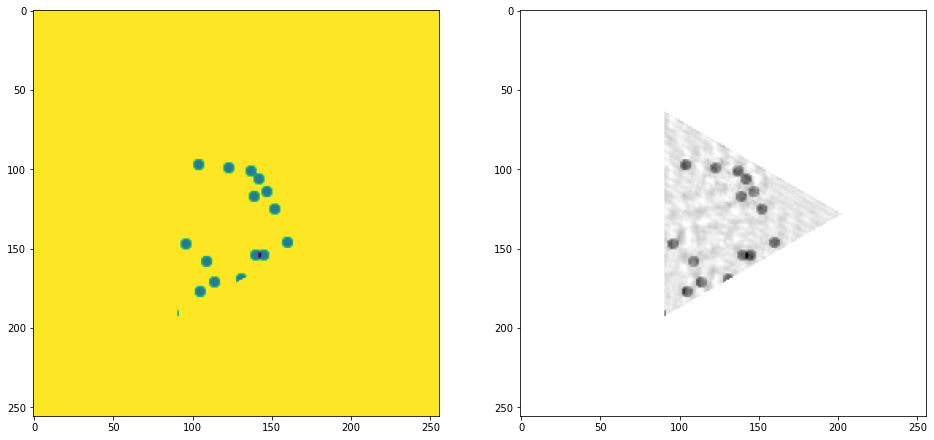

In [395]:
fig = plt.figure(figsize = [16, 8])

ax = plt.subplot(1,2,1)
im = plt.imshow(np.angle(AuNPimg[:,:,0])*aperture,vmax=0)

ax2 = plt.subplot(1,2,2)
im = plt.imshow(np.angle(inv)*aperture,cmap='gray',vmax=0)

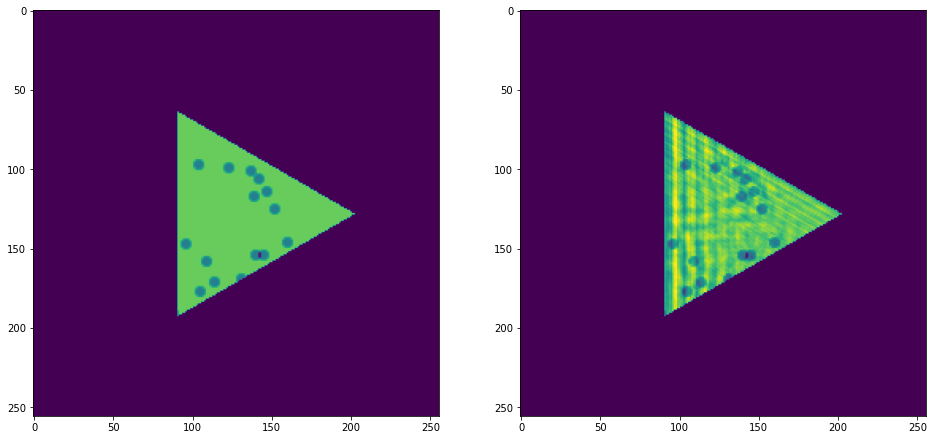

In [393]:
fig = plt.figure(figsize = [16, 8])

ax = plt.subplot(1,2,1)
im = plt.imshow(np.real(AuNPimg[:,:,0])*aperture,vmax=1.3)

ax2 = plt.subplot(1,2,2)
im = plt.imshow(np.real(inv)*aperture,vmax=1.3)

In [383]:
(np.real(AuNPimg[:,:,0])*aperture)[region_mask].max(),(np.real(AuNPimg[:,:,0])*aperture)[region_mask].min()

(1.0, 0.1024967920819983)

In [384]:
(np.angle(AuNPimg[:,:,0])*aperture)[region_mask].max(),(np.angle(AuNPimg[:,:,0])*aperture)[region_mask].min()

(0.0, -1.4305634847202824)

In [387]:
(np.abs(AuNPimg[:,:,0])*aperture)[region_mask].max(),(np.abs(AuNPimg[:,:,0])*aperture)[region_mask].min()

(1.0, 0.733305411222935)

In [385]:
(np.real(inv)*aperture)[region_mask].max(),(np.real(inv)*aperture)[region_mask].min()

(1.4249394168012688, 0.0816324111414473)

In [388]:
(np.abs(inv)*aperture)[region_mask].max(),(np.abs(inv)*aperture)[region_mask].min()

(1.443782558966185, 0.5292625104661597)

In [386]:
(np.angle(inv)*aperture)[region_mask].max(),(np.angle(inv)*aperture)[region_mask].min()

(-1.3975301555436066e-05, -1.464984818349112)

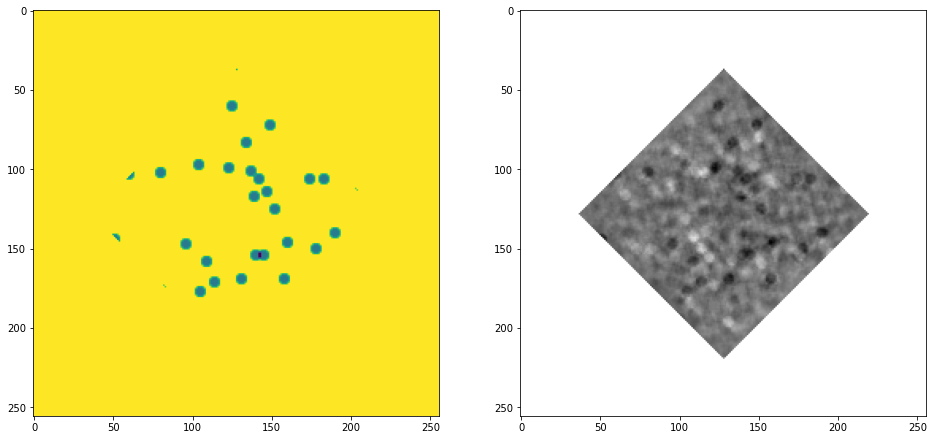

In [406]:
fig = plt.figure(figsize = [16, 8])

ax = plt.subplot(1,2,1)
im = plt.imshow(np.angle(AuNPimg[:,:,0])*aperture,vmax=0)

ax2 = plt.subplot(1,2,2)
im = plt.imshow(np.angle(inv)*aperture,cmap='gray',vmax=0)

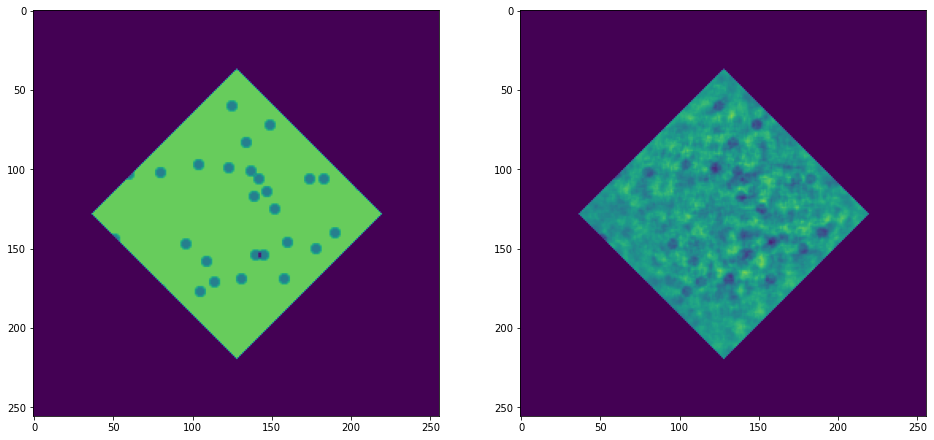

In [409]:
fig = plt.figure(figsize = [16, 8])

ax = plt.subplot(1,2,1)
im = plt.imshow(np.real(AuNPimg[:,:,0])*aperture,vmax=1.3)

ax2 = plt.subplot(1,2,2)
im = plt.imshow(np.real(inv)*aperture,vmax=1.3)